In [338]:
import data
from sklearn.model_selection import ShuffleSplit
from skimage.feature import hog
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import preprocess
import cv2
import itertools
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import model
import copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import glob
import slide
import postprocess
%matplotlib inline

In [2]:
# Read in all the car and non-car classes
vehicle_data = data.retrieve_data("vehicles")
non_vehicle_data = data.retrieve_data("non-vehicles")

# TODO: Ensure there is no class imbalance; fix as necessary
df = pd.concat([vehicle_data, non_vehicle_data])
df

,category,subcategory,image
0,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1.png
1,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/10.png
2,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1000.png
3,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1001.png
4,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1002.png
5,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1003.png
6,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1004.png
7,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1005.png
8,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1006.png
9,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1007.png


In [324]:
# Shuffle and do train-test split

# TODO Later: Split the data manually so that time series issues do not impact the validation results
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(df)

# Since n_splits is 1, generator should only produce one object
train_idx, test_idx = next(cv)

df['dataset'] = 'test'
df['dataset'].iloc[train_idx.tolist()] = 'train'


print("Length of data: ", len(df))

Length of data:  9866


In [14]:
# For optimizing the subset, we need to be able to rely on validation figures
# Hence, we only use KITTI_extracted data given that the other data sets have timelapse info
# (i.e. high correlation between some images) + non-vehicles images
subset_df = pd.concat([df[df['subcategory'] == 'KITTI_extracted'], df[df['category'] == 'non-vehicles']])

subset_df

,category,subcategory,image,dataset
0,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1.png,train
1,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/10.png,train
2,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1000.png,train
3,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1001.png,train
4,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1002.png,train
5,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1003.png,train
6,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1004.png,train
7,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1005.png,train
8,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1006.png,train
9,vehicles,KITTI_extracted,training_images/vehicles/KITTI_extracted/1007.png,test


In [15]:
# Extract HOG features and optimize the hyperparameters

X_scaler = MinMaxScaler()
#X_scaler.fit_transform(X_train)

# Assume we can optimize variables independently
# Hence, we start with some basic parameters which we will then modify.
colorspace = 'RGB'
orient = 9 # number of orientation bins
pix_per_cell = 8 # number of pixels to calculate the gradient
cell_per_block = 2 # the local area over which the histogram counts in a given cell will be normalized

# Since hog takes a single channel, iterate over different channels
colorspaces = ['RGB', 'HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']
orients = range(7, 13) # 7 to 12
pix_per_cells = range(6, 11) # 6 to 10
cell_per_blocks = range(1, 4) #1 to 3)

def get_all_hog_features(df, colorspace, orient, pix_per_cell, cell_per_block):
    total_hog_features = []
    for (idx, item) in df.iterrows():
        # Read in image
        img = cv2.imread(item['image'])
        #img = mpimg.imread(item['image'])
        if colorspace != 'RGB':
            conv_img = cv2.cvtColor(img, eval("cv2.COLOR_BGR2" + colorspace))
        else:
            conv_img = np.copy(img)
            
        hog_features = []
        for chan in range(conv_img.shape[2]):
            hog_features = np.hstack([hog_features, preprocess.get_hog_features(conv_img[:,:,chan], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)])
            
        total_hog_features.append(hog_features)
        
    return np.array(total_hog_features)

def optimize_parameter_set(params_set):
    test_accuracies = []    
    for params in params_sets:
        train_df = subset_df[subset_df['dataset'] == 'train']
        test_df = subset_df[subset_df['dataset'] == 'test']

        X_train = get_all_hog_features(train_df, 
                                       params["colorspace"], 
                                       params["orient"], 
                                       params["pix_per_cell"], 
                                       params["cell_per_block"])
        X_train = X_scaler.fit_transform(np.array(X_train))
        le = LabelEncoder()
        y_train = le.fit_transform(train_df['category'])
        svc_model = model.return_model()
        svc_model.fit(X_train, y_train)

        X_test = get_all_hog_features(test_df, 
                                       params["colorspace"], 
                                       params["orient"], 
                                       params["pix_per_cell"], 
                                       params["cell_per_block"])
        X_test = X_scaler.transform(np.array(X_test))
        y_test = le.transform(test_df['category'])
        test_accuracy = svc_model.score(X_test, y_test)
        print('Test Accuracy of SVC = ', svc_model.score(X_test, y_test))
        test_accuracies.append(test_accuracy)
    
    optimum_params = params_sets[np.argmax(test_accuracies)]
    return optimum_params, np.max(test_accuracies)

indp_params_to_optimize = [("colorspace", colorspaces), ("orient", orients), ("pix_per_cell", pix_per_cells), ("cell_per_block", cell_per_blocks)]

# starting point
base_params = {"colorspace": 'RGB', "orient": 9, "pix_per_cell": 8, "cell_per_block": 2}
for name, param_set in indp_params_to_optimize:
    # Optimize it and continue
    # build dictionary
    params_sets = []
    for param in param_set:
        params_set = copy.copy(base_params)
        params_set[name] = param
        params_sets.append(params_set)
        
    optimum_params, test_accuracy = optimize_parameter_set(params_sets)
    base_params = optimum_params
        
    print("Optimized parameter: ", name, ". Test accuracy: ", test_accuracy, ". New parameter set: ", base_params)

print("Final optimized parameters: ", base_params)



Test Accuracy of SVC =  0.991894630193
Test Accuracy of SVC =  0.995947315096
Test Accuracy of SVC =  0.997973657548
Test Accuracy of SVC =  0.995947315096
Test Accuracy of SVC =  0.998480243161
Test Accuracy of SVC =  0.997973657548
Optimized parameter:  colorspace . Test accuracy:  0.997973657548 . New parameter set:  {'orient': 9, 'colorspace': 'YUV', 'pix_per_cell': 8, 'cell_per_block': 2}
Test Accuracy of SVC =  0.996960486322
Test Accuracy of SVC =  0.998480243161
Test Accuracy of SVC =  0.998480243161
Test Accuracy of SVC =  0.998986828774
Test Accuracy of SVC =  0.997973657548
Test Accuracy of SVC =  0.999493414387
Optimized parameter:  orient . Test accuracy:  0.999493414387 . New parameter set:  {'orient': 12, 'colorspace': 'YUV', 'pix_per_cell': 8, 'cell_per_block': 2}
Test Accuracy of SVC =  0.998986828774
Test Accuracy of SVC =  0.997973657548
Test Accuracy of SVC =  0.999493414387
Test Accuracy of SVC =  0.999493414387
Test Accuracy of SVC =  0.998986828774
Optimized para

In [325]:
# From the above run and analyzing the trends of gridsearch, we choose the following hyperparameters:

colorspace = 'YUV'
orient = 10 # number of orientation bins (we didn't choose 12 because we see that 11 actually goes down - we don't want to overfit!)
pix_per_cell = 8 # number of pixels to calculate the gradient
cell_per_block = 2 # the local area over which the histogram counts in a given cell will be normalized

# Create a model using all the data (Balance the vehicles and non-vehicles classes through sampling for removing bias)
len_imbalance = sum(df["category"] == "vehicles") - sum(df["category"] == "non-vehicles")
balanced_df = pd.concat([df[df["category"] == "non-vehicles"], \
                         df[df["category"] == "non-vehicles"].sample(len_imbalance, replace=True), \
                         df[df["category"] == "vehicles"]])

X_train = get_all_hog_features(balanced_df, colorspace, orient, pix_per_cell, cell_per_block)
X_train = X_scaler.fit_transform(np.array(X_train))
y_train = le.fit_transform(balanced_df['category'])
svc_model = model.return_model()
svc_model.fit(X_train, y_train)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

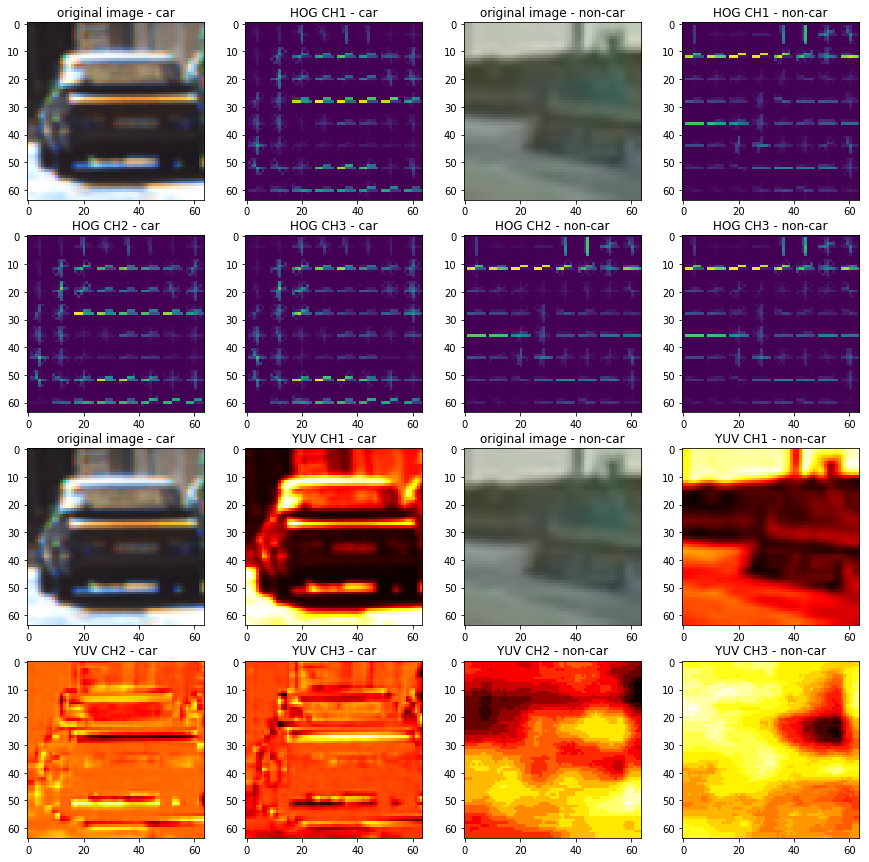

In [53]:
# For a car and non-car image:
# Plot the image, image channels, HOG 

example_car = df[df['category'] == 'vehicles'].iloc[0]['image']
example_non_car = df[df['category'] == 'non-vehicles'].iloc[1]['image']

gs = gridspec.GridSpec(4, 4)
fig = plt.figure(figsize=(15,15))

img = cv2.imread(example_car)
offset = 0
for cls in ["car", "non-car"]:
    if cls == "car":
        img = cv2.imread(example_car)
    else:
        img = cv2.imread(example_non_car)
    yuv_img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    ax = plt.subplot(gs[0,offset+0])
    ax.imshow(img)
    ax.set_title("original image - " + cls)
    
    hogax0 = plt.subplot(gs[0, offset+1])
    hog0 = preprocess.get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)[1]
    hogax0.imshow(hog0)
    hogax0.set_title("HOG CH1 - " + cls)
    
    hogax1 = plt.subplot(gs[1, offset+0])
    hog1 = preprocess.get_hog_features(img[:,:,1], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)[1]
    hogax1.imshow(hog1)
    hogax1.set_title("HOG CH2 - " + cls)
    
    hogax2 = plt.subplot(gs[1, offset+1])
    hog2 = preprocess.get_hog_features(img[:,:,2], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)[1]
    hogax2.imshow(hog2)
    hogax2.set_title("HOG CH3 - " + cls)
    
    ax1 = plt.subplot(gs[2, offset+0])
    ax1.imshow(img)
    ax1.set_title("original image - " + cls)
    ax2 = plt.subplot(gs[2, offset+1])
    ax2.imshow(yuv_img[:,:,0], cmap="hot")
    ax2.set_title("YUV CH1 - " + cls)
    ax3 = plt.subplot(gs[3, offset+0])
    ax3.imshow(yuv_img[:,:,1], cmap="hot")
    ax3.set_title("YUV CH2 - " + cls)
    ax4 = plt.subplot(gs[3, offset+1])
    ax4.imshow(yuv_img[:,:,2], cmap="hot")
    ax4.set_title("YUV CH3 - " + cls)
    offset += 2


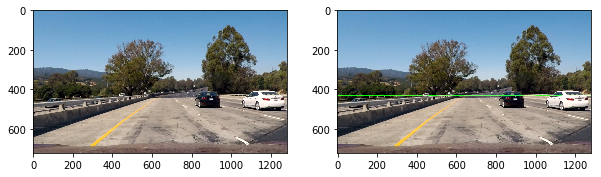

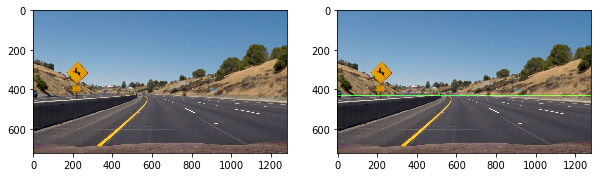

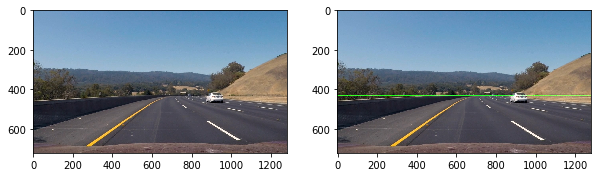

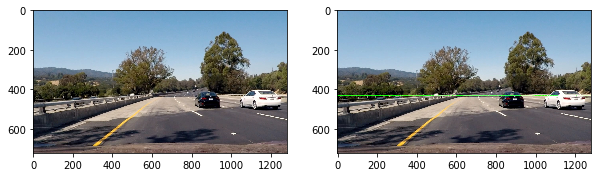

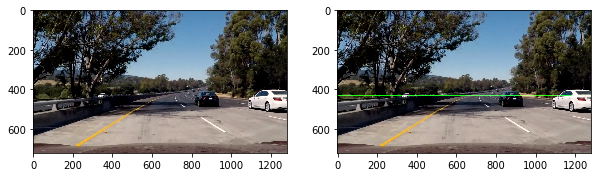

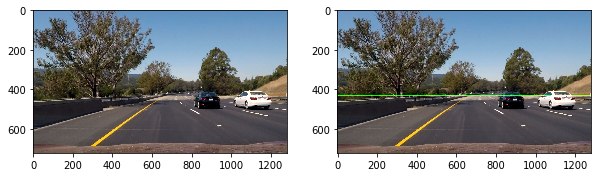

In [96]:
# Read in test images and find the horizon

test_image_paths = glob.glob("test_images/*.jpg")

for path in test_image_paths:
    img = plt.imread(path)
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(221)
    ax.imshow(img)

    # Draw a line representing the horizon cutoff
    overlay = np.zeros_like(img)
    y_coord = 430
    overlay[y_coord-4:y_coord+4, :,1] = 255
    img = cv2.addWeighted(img, 1, overlay, 1, 0)
    
    ax = plt.subplot(222)
    ax.imshow(img)
    
    plt.show()
    

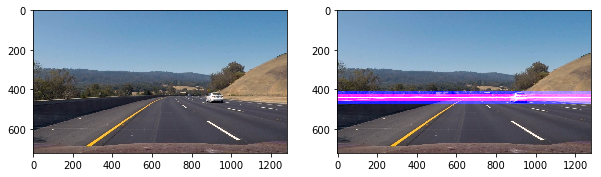

In [218]:
# Create a function that linearly scales width as it progresses down the image such that it
# boxes in the closest car

def estimate_width(offset_px):
    return max(int(offset_px * 45 / 14), 10), max(int(offset_px * 45 / 7), 10)

# Read in test images and find the horizon

offset = 10

path = glob.glob("test_images/*.jpg")[2]

img = plt.imread(path)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(221)
ax.imshow(img)

# Draw a line representing the horizon cutoff
overlay = np.zeros_like(img)
y_coord = 430 + offset
overlay[y_coord-4:y_coord+4, :,1] = 255

min_width, max_width = estimate_width(offset)
overlay[y_coord-int(min_width/2):y_coord+int(min_width/2), :,0] = 255
overlay[y_coord-int(max_width/2):y_coord+int(max_width/2), :,2] = 255

img = cv2.addWeighted(img, 1, overlay, 1, 0)

ax = plt.subplot(222)
ax.imshow(img)

plt.show()
    



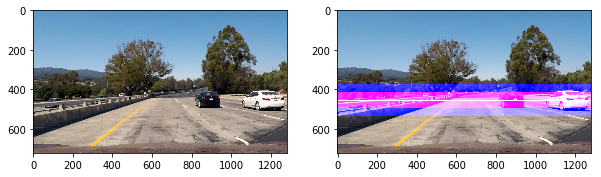

In [219]:
# Test the bounding strip on a nearer car

offset = 25

path = glob.glob("test_images/*.jpg")[0]

img = plt.imread(path)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(221)
ax.imshow(img)

# Draw a line representing the horizon cutoff
overlay = np.zeros_like(img)
y_coord = 430 + offset
overlay[y_coord-4:y_coord+4, :,1] = 255

min_width, max_width = estimate_width(offset)
overlay[y_coord-int(min_width/2):y_coord+int(min_width/2), :,0] = 255
overlay[y_coord-int(max_width/2):y_coord+int(max_width/2), :,2] = 255

img = cv2.addWeighted(img, 1, overlay, 1, 0)

ax = plt.subplot(222)
ax.imshow(img)

plt.show()

In [220]:
# Extract a critical video frame from the project

def extract_vid_frames():
    vidcap = cv2.VideoCapture('project_video.mp4')
    success,image = vidcap.read()
    count = 0
    success = True
    while success:
        success,image = vidcap.read()
        #cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
        if cv2.waitKey(10) == 27:                     # exit if Escape is hit
            break
        if count in [176, 731] :
            # Convert to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imsave("project_test_images/%d.jpg" % count, image_rgb)
        count += 1

#extract_vid_frames()
# There are 1260 frames

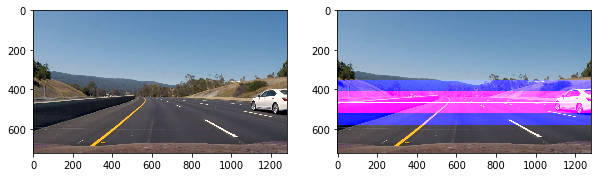

In [221]:
# Test the bounding strip on extracted images of the project video

offset = 35

path = glob.glob("project_test_images/*.jpg")[0]

img = plt.imread(path)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(221)
ax.imshow(img)

# Draw a line representing the horizon cutoff
overlay = np.zeros_like(img)
y_coord = 430 + offset
overlay[y_coord-4:y_coord+4, :,1] = 255

min_width, max_width = estimate_width(offset)
overlay[y_coord-int(min_width/2):y_coord+int(min_width/2), :,0] = 255
overlay[y_coord-int(max_width/2):y_coord+int(max_width/2), :,2] = 255

img = cv2.addWeighted(img, 1, overlay, 1, 0)

ax = plt.subplot(222)
ax.imshow(img)

plt.show()

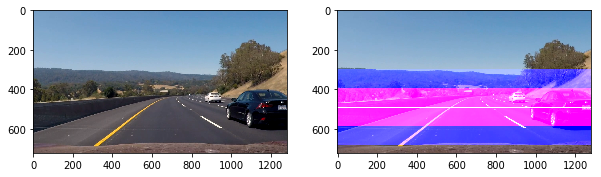

In [222]:
# Test the bounding strip on extracted images of the project video

offset = 60

path = glob.glob("project_test_images/*.jpg")[1]

img = plt.imread(path)
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(221)
ax.imshow(img)

# Draw a line representing the horizon cutoff
overlay = np.zeros_like(img)
y_coord = 430 + offset
overlay[y_coord-4:y_coord+4, :,1] = 255

min_width, max_width = estimate_width(offset)
overlay[y_coord-int(min_width/2):y_coord+int(min_width/2), :,0] = 255
overlay[y_coord-int(max_width/2):y_coord+int(max_width/2), :,2] = 255

img = cv2.addWeighted(img, 1, overlay, 1, 0)

ax = plt.subplot(222)
ax.imshow(img)

plt.show()

# bboxes:  10800


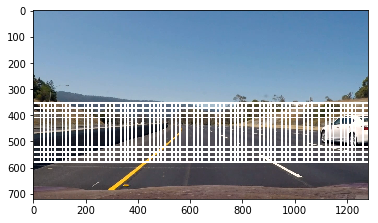

In [229]:
# Experiment with bbox sizin

# scan linearly 20 rows
n_rows = 20
width_step_proportion = 0.25 # Amount of width to skip
n_y_windows_per_row = 4
n_x_windows_per_row = 5

path = glob.glob("project_test_images/*.jpg")[0]
img = plt.imread(path)

horizon = 430

bboxes = []
for row in range(n_rows):
    y_offset = row * (img.shape[0] - horizon) / n_rows
    y_offset = 35
    min_car_height, max_car_height = estimate_width(y_offset)
    # There's more variability in the width of a car than the height:
    car_min_width, car_max_width = min_car_height, int(1.5 * max_car_height)
    
    # Create a grid of boxes
    for height in np.linspace(min_car_height, max_car_height, n_y_windows_per_row):
        x_coord = 0
        for width in np.linspace(car_min_width, car_max_width, n_x_windows_per_row): 
            for x_offset in np.arange(0, img.shape[1], int(width * width_step_proportion)):
                # Draw bboxes about the y-axis where the x_offset is from 0 to end - width
                bboxes.append(((int(x_offset), horizon + y_offset - int(height/2)), (int(x_offset + width), horizon + y_offset + int(height/2))))
                
print("# bboxes: ", len(bboxes))
bbox_img = slide.draw_boxes(img, bboxes)
plt.imshow(bbox_img)


PATH:  project_test_images/176.jpg


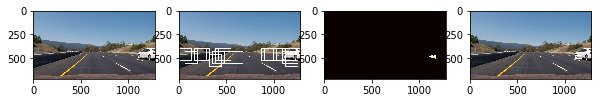

PATH:  project_test_images/731.jpg


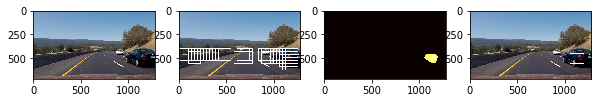

PATH:  test_images/test1.jpg


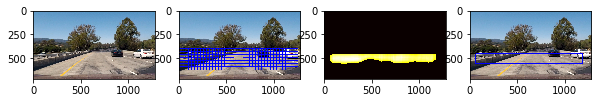

PATH:  test_images/test2.jpg


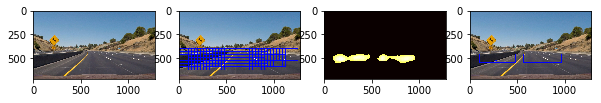

PATH:  test_images/test3.jpg


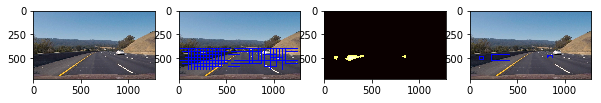

PATH:  test_images/test4.jpg


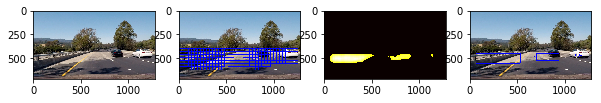

PATH:  test_images/test5.jpg


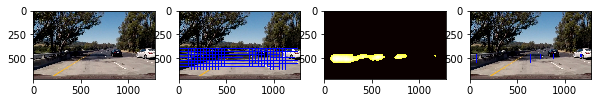

PATH:  test_images/test6.jpg


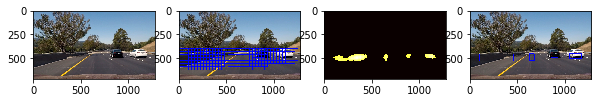

In [374]:
# Perform a sliding window search for hogs data
import importlib
importlib.reload(model)
importlib.reload(postprocess)
paths = glob.glob("project_test_images/*.jpg")
paths += glob.glob("test_images/*.jpg")

ystart = 400
ystop = 656
bboxes = []

#scale_and_thresholds = [(1, 15)]
# scale from 1 to 2
thres = 100
#for scale, thres in scale_and_thresholds:
for path in paths:
    print('PATH: ', path)
    img = plt.imread(path)
    bboxes = []
    for scale in np.linspace(1,2,9):
        bboxes_sset, bbox_img = model.find_cars_hog(img, ystart, ystop, scale, svc_model, le, X_scaler, orient, pix_per_cell, cell_per_block)
        bboxes += bboxes_sset
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = postprocess.add_heat(heat,bboxes, 1)   
    # Apply threshold to help remove false positives
    heat = postprocess.apply_threshold(heat,thres)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = postprocess.label(heatmap)
    draw_img = postprocess.draw_labeled_bboxes(np.copy(img), labels)

    # Draw the original image, heatmap and resultant bboxes
    fig = plt.figure(figsize=(10,10))        
    plt.subplot(141).imshow(img)
    plt.subplot(142).imshow(bbox_img)
    plt.subplot(143).imshow(heatmap, cmap='hot')
    plt.subplot(144).imshow(draw_img)

    plt.show()

PATH:  project_test_images/176.jpg


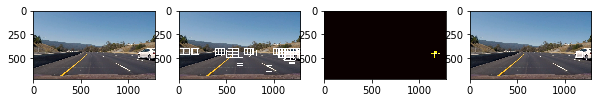

PATH:  project_test_images/731.jpg


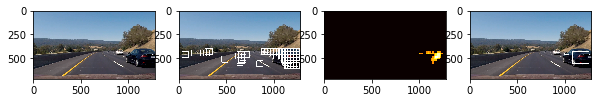

PATH:  test_images/test1.jpg


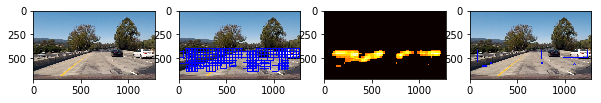

PATH:  test_images/test2.jpg


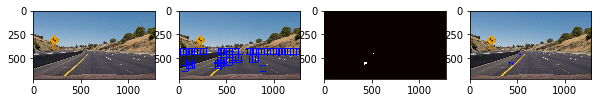

PATH:  test_images/test3.jpg


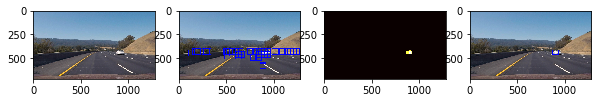

PATH:  test_images/test4.jpg


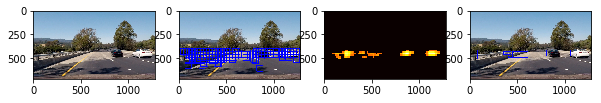

PATH:  test_images/test5.jpg


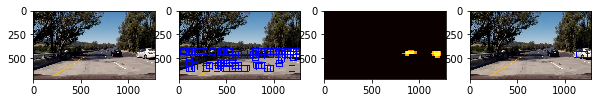

PATH:  test_images/test6.jpg


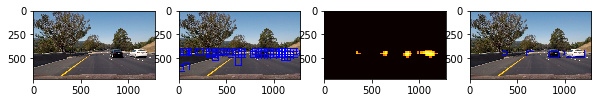

In [368]:
# Perform a sliding window search for hogs data
import importlib
importlib.reload(model)
importlib.reload(postprocess)
paths = glob.glob("project_test_images/*.jpg")
paths += glob.glob("test_images/*.jpg")

ystart = 400
ystop = 656
bboxes = []

scale_and_thresholds = [(1, 7, 1)]
for scale, thres, heatscale in scale_and_thresholds:
    for path in paths:
        print('PATH: ', path)
        img = plt.imread(path)
        bboxes = []
        bboxes_sset, bbox_img = model.find_cars_hog(img, ystart, ystop, scale, svc_model, le, X_scaler, orient, pix_per_cell, cell_per_block)
        bboxes += bboxes_sset
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        # Add heat to each box in box list
        heat = postprocess.add_heat(heat,bboxes, heatscale)   
        # Apply threshold to help remove false positives
        heat = postprocess.apply_threshold(heat,thres)
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = postprocess.label(heatmap)
        draw_img = postprocess.draw_labeled_bboxes(np.copy(img), labels)

        # Draw the original image, heatmap and resultant bboxes
        fig = plt.figure(figsize=(10,10))        
        plt.subplot(141).imshow(img)
        plt.subplot(142).imshow(bbox_img)
        plt.subplot(143).imshow(heatmap, cmap='hot')
        plt.subplot(144).imshow(draw_img)

        plt.show()

In [261]:
bboxes[:5]

[((0, 400), (64, 464)),
 ((0, 416), (64, 480)),
 ((0, 432), (64, 496)),
 ((0, 448), (64, 512)),
 ((0, 464), (64, 528))]

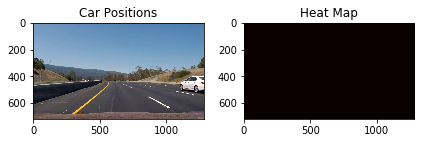

In [339]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage.measurements import label

path = glob.glob("project_test_images/*.jpg")[0]
img = plt.imread(path)
heat = np.zeros_like(img[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,bboxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,150)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [ ]:
# Train data

# cv2.imread()

# TODO: Normalize data using sklearn.preprocessing.StandardScaler()

# SVM's work well with HOG features


### TODO: Tweak these parameters and see how the results change.
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)